In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import json
import saliency
tfk  = tf .keras
tfkl = tfk.layers
from utils import *
from guided_ig import *
from tqdm import tqdm
from sklearn.metrics import auc
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter
from insertion_deletion import CausalMetric, gkern
import pickle
import torch
import re
from datetime import datetime

from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.keras.layers.preprocessing import image_preprocessing

In [7]:
p_jpg = '/media/big/imagenet/data/ILSVRC/Data/CLS-LOC/train'

In [4]:
with open('imagenet_class_index.json', 'r') as fp:
    label_json = json.loads(fp.read())
labels = np.array([
    [k, *v]
    for k, v in label_json.items()
])

In [6]:
model = tf.keras.applications.InceptionV3()

In [15]:
# Basketball
bball = int(labels[labels[:, 1] == 'n02802426'][0][0])

# Labrador
labra = int(labels[labels[:, 1] == 'n02099712'][0][0])

In [19]:
# For Grad-CAM
model_body = tfk.Model(model.input, model.get_layer('mixed10').output)

# For RISE
s = 8
p = 0.1
N = 1000
rise_batch = 10
cell_size = np.ceil(np.array((299, 299)) / s)
up_size   = (s + 1) * cell_size

grid  = (np.random.rand(N, s, s) < p).astype('float')
rise_masks = np.zeros((N, 299, 299))
for idx in range(N):
    x = np.random.randint(0, cell_size[0])
    y = np.random.randint(0, cell_size[1])
    rise_masks[idx] = resize(
        grid[idx], 
        up_size,
        order = 1,
        mode  = 'reflect',
        anti_aliasing = False
    )[x : x + 299, y : y + 299]
rise_masks = rise_masks[..., np.newaxis]

jpg = f'{p_jpg}/n02802426/n02802426_5541.jpg'

# Load image
img = io_ops.read_file(jpg)
img = image_ops.decode_image(
    img, 
    channels = 3, 
    expand_animations = False
)
img = image_ops.resize_images_v2(
    img, 
    (299, 299), 
    method = image_preprocessing.get_interpolation('bilinear')
)
img.set_shape((299, 299, 3))
img = tfk.applications.inception_v3.preprocess_input(img)
image = img[tf.newaxis]

allm = []
for best_idx in [bball, labra]:

    gig = unbounded_guided_ig(
        img.numpy(),
        np.zeros_like(img) - 1, 
        200, 
        lambda x: grad_func(x, best_idx), 
        0.1
    )

    gig20 = anchored_guided_ig(
        img.numpy(),
        np.zeros_like(img) - 1, 
        lambda x: grad_func(x, best_idx), 
        200, 
        0.1,
        anchors = 20
    )

    # Compute IG

    baseline = tf.zeros_like(image) - 1

    steps = 200
    batch = 25

    delta  = (image - baseline) / steps
    alpha  = tf.cast(tf.linspace(0, steps, steps)[:, tf.newaxis, tf.newaxis, tf.newaxis], tf.float32)
    inputs = baseline + (alpha * delta)

    ig = np.zeros_like(image)
    pointer = 0
    while pointer < steps:
        inp = tf.gather(inputs, tf.range(pointer, pointer + batch))
        with tf.GradientTape() as tape:
            tape.watch(inp)
            pred = model(inp)
            pred = pred[:, best_idx]
        grd = tape.gradient(pred, inp)
        ig += tf.reduce_sum(grd, 0).numpy()
        pointer += batch

    with tf.GradientTape() as tape:
        body_output = model_body(image)
        tape.watch(body_output)
        pred = model.layers[-1](model.layers[-2](body_output))
        pred = pred[:, best_idx]
    gc = tape.gradient(pred, body_output)
    gc = tf.nn.relu(
        tf.reduce_sum(
            tfkl.GlobalAveragePooling2D()(
                gc)[tf.newaxis, tf.newaxis] * body_output, 
            (0, -1)
        )
    )[..., tf.newaxis]
    gc = image_ops.resize_images_v2(
        gc, 
        (299, 299), 
        image_preprocessing.get_interpolation('bilinear')
    )

    rise = []
    for bidx in range(N // rise_batch):

        rmp = rise_masks[bidx * rise_batch : (bidx + 1) * rise_batch]
        rise_tmp = rmp * image
        p_rise = model.predict(rise_tmp, batch_size = rise_batch)
        risep  = np.squeeze((p_rise[:, best_idx].reshape((-1, 1, 1, 1)) * rmp).sum(0))
        rise.append(risep)

    rise = np.stack(rise).sum(0)
    
    allm.append([
        
        ig.mean((0, -1)), 
        gig.mean(-1), 
        gig20.mean(-1), 
        gc.numpy().mean(-1), 
        rise
    ])

In [26]:
from util import vis_grad
from utils import *

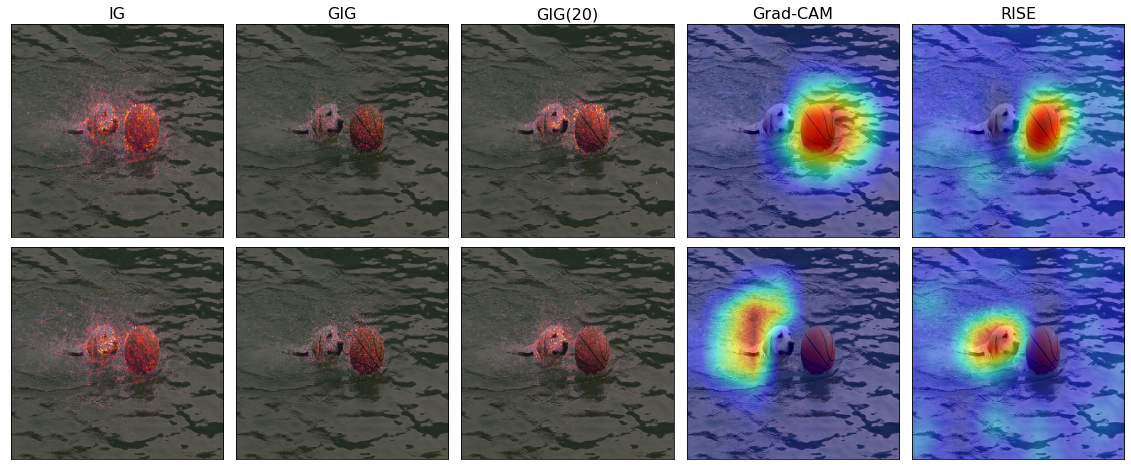

In [58]:
img_plot = to_unitrange(image.numpy()[0])

rows = 2
cols = 5
fig, axes = plt.subplots(
    nrows = rows,
    ncols = cols,
    figsize = (4 * cols, 4 * rows)
)

titles = ['IG', 'GIG', 'GIG(20)', 'Grad-CAM', 'RISE']

fig.subplots_adjust(hspace = 0.05, wspace = 0.05)
for idx in range(rows):
    for jdx in range(cols):
        
        axes[idx][jdx].set_xticks([])
        axes[idx][jdx].set_yticks([])
        
        if jdx < 3:
            attr, cmap, norm = vis_grad(
                torch.from_numpy(allm[idx][jdx].reshape((1, 299, 299))).permute(1, 2, 0),
                min = 0, max = 1,
                polarity = 'both'
            )
            axes[idx][jdx].imshow(img_plot, alpha = 0.8)
            axes[idx][jdx].imshow(attr, cmap = cmap, norm = norm, alpha = 0.6)
        else:
            axes[idx][jdx].imshow(img_plot)
            axes[idx][jdx].imshow(
                allm[idx][jdx],
                cmap = 'jet',
                alpha = 0.5
            )
        
        if idx == 0:
            axes[idx][jdx].set_title(titles[jdx], fontsize = 16)
            
plt.savefig('DOG-AND-BALL.pdf', bbox_inches = 'tight')
plt.show()